In [1]:
import os
import cv2
import glob
import pickle
import numpy as np
from tqdm import tqdm
from keras.utils import normalize
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from matplotlib.patches import Rectangle

seed = 42
SIZE_X = 256
SIZE_Y = 256
n_channels = 3
n_classes = 10
Batch_size = 16
EPOCHS = 100
MODEL = 'unet'
activation = 'softmax'
BACKBONE = 'resnet34'
encoder_weights = 'imagenet'
parent_directory = r'E:/Segmentation/datasets/FloodNet(Patches_512x512)_customized'

In [2]:
class_map= {'Background':0, 'Building-flooded':1, 'Building-non-flooded':2, 'Road-flooded':3, 'Road-non-flooded':4, 'Water':5, 'Tree':6, 'Vehicle':7, 'Pool':8, 'Grass':9}
    
color_map = {'Background':[0, 0, 0], 'Building-flooded':[196, 0, 0], 'Building-non-flooded': [255,128,128], 'Road-flooded':[128, 128, 0],  'Road-non-flooded':[128, 128, 128], 
                 'Water': [0, 191, 255], 'Tree':[34, 139, 34], 'Vehicle': [123, 37, 118],  'Pool':[0, 68, 255],'Grass':[127, 224, 104]}

handles = [Rectangle((0,0),1,1, color = (np.array(c)/255)) for n,c in color_map.items()]

labels = [n for n,c in color_map.items()]


def to_RGB(label):
    """
    Suply our labale masks as input in RGB format. 
    Replace pixels with specific RGB values ...
    """    
    label_seg = np.zeros(label.shape,dtype=np.uint8)
    for key, val in class_map.items():
      label_seg [np.all(label == class_map[key],axis=-1)] = color_map[key]  
    return label_seg

def display_images_with_masks(image, mask, predicted):
    plt.figure(figsize=(12, 8))
    plt.subplot(131)
    plt.title('Testing Image')
    plt.imshow(image)
    plt.subplot(132)
    plt.title('Testing Label')
    plt.imshow(to_RGB(np.tile(np.expand_dims(mask, axis=-1), (1, 1, 3)))) 
    plt.subplot(133)
    plt.title('Prediction')
    plt.imshow(to_RGB(np.tile(np.expand_dims(predicted, axis=-1), (1, 1, 3))))
    plt.legend(handles, labels, bbox_to_anchor =(-0.8,-0.5), loc='lower center', ncol=5)
    plt.show()

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict()
mask_data_gen_args = dict()

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory(f"{parent_directory}/train_images",
                                                           seed=seed,
                                                           batch_size=Batch_size,
                                                           class_mode=None,
                                                           target_size=(SIZE_X, SIZE_Y))

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory(f"{parent_directory}/train_masks",
                                                         seed=seed,
                                                         batch_size=Batch_size,
                                                         color_mode = 'grayscale',
                                                         class_mode=None,
                                                         target_size=(SIZE_X, SIZE_Y))


valid_img_generator = image_data_generator.flow_from_directory(f"{parent_directory}/val_images",
                                                           seed=seed,
                                                           batch_size=Batch_size,
                                                           class_mode=None,
                                                           target_size=(SIZE_X, SIZE_Y))

valid_mask_generator = mask_data_generator.flow_from_directory(f"{parent_directory}/val_masks",
                                                         seed=seed,
                                                         batch_size=Batch_size,
                                                         color_mode = 'grayscale',
                                                         class_mode=None,
                                                         target_size=(SIZE_X, SIZE_Y))

train_generator = zip(image_generator, mask_generator)
valid_generator = zip(valid_img_generator, valid_mask_generator)

Found 50575 images belonging to 1 classes.
Found 50575 images belonging to 1 classes.
Found 15750 images belonging to 1 classes.
Found 15750 images belonging to 1 classes.


In [4]:
batch = next(train_generator)
images, masks = batch

In [6]:
images.shape, masks.shape

((16, 256, 256, 3), (16, 256, 256, 1))

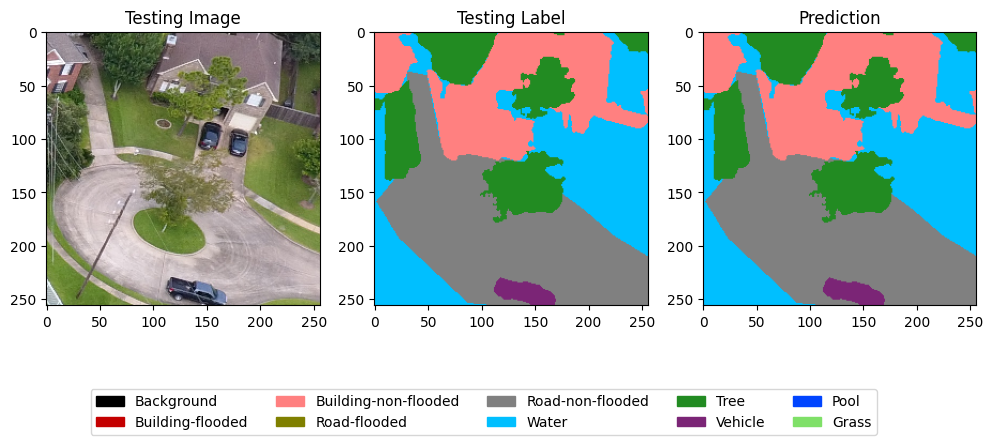

In [9]:
import numpy as np
import random

num = random.randint(0, len(images)-1)
display_images_with_masks((images[num]).astype(np.uint8), np.squeeze(masks[num], axis=-1), np.squeeze(masks[num], axis=-1))

In [7]:
def preprocess_data(images, masks, unet_preporcessing=None):
    if unet_preporcessing:
        images = unet_preporcessing(images)
    else:
        images = normalize(images, axis=1)

    masks = np.expand_dims(masks, axis=-1)
    masks = to_categorical(masks, num_classes=n_classes)
    masks = masks.reshape((masks.shape[0], masks.shape[1], masks.shape[2], n_classes))

    return images, masks

In [8]:
def load_data(image_generator, mask_generator, preprocessing_function=None):
    for (img, mask) in zip(image_generator, mask_generator):
        img, mask = preprocess_data(img, mask, preprocessing_function)
        yield (img, mask)

In [9]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm

preprocess_input = sm.get_preprocessing(BACKBONE)

Segmentation Models: using `tf.keras` framework.


In [8]:
train_generator = load_data(image_generator, mask_generator, preprocess_input)
val_generator = load_data(valid_img_generator, valid_mask_generator, preprocess_input)

In [9]:
batch = next(train_generator)
images, masks = batch

In [10]:
images[0].shape, masks[0].shape

((256, 256, 3), (256, 256, 10))

In [16]:
images.shape, masks.shape

((16, 256, 256, 3), (16, 256, 256, 10))

In [10]:
if MODEL == 'unet':
    model = sm.Unet(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
elif MODEL == 'fpn':
    model = sm.FPN(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
elif MODEL == 'pspnet':
    model = sm.PSPNet(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
elif MODEL == 'linknet':
    model = sm.Linknet(BACKBONE, input_shape=(SIZE_X, SIZE_Y, n_channels), classes=n_classes, encoder_weights=encoder_weights,  activation=activation)
else:
    raise ValueError('Unknown model')

model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 data (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 bn_data (BatchNormalization)   (None, 256, 256, 3)  9           ['data[0][0]']                   
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 262, 262, 3)  0          ['bn_data[0][0]']                
                                                                                                  
 conv0 (Conv2D)                 (None, 128, 128, 64  9408        ['zero_padding2d[0][0]']   

In [11]:
train_samples = len(os.listdir(f"{parent_directory}/train_images/train"))
val_samples = len(os.listdir(f"{parent_directory}/val_images/val"))
train_samples, val_samples

(50575, 15750)

In [19]:
history = model.fit(train_generator, steps_per_epoch=(train_samples//Batch_size), epochs=EPOCHS, validation_data=val_generator, validation_steps=(val_samples//Batch_size))

Epoch 1/100
3160/3160 [==============================] - 694s 216ms/step - loss: 0.8815 - iou_score: 0.2586 - val_loss: 0.9429 - val_iou_score: 0.2327
Epoch 2/100
3160/3160 [==============================] - 669s 212ms/step - loss: 0.7913 - iou_score: 0.3268 - val_loss: 0.8325 - val_iou_score: 0.2948
Epoch 3/100
3160/3160 [==============================] - 676s 214ms/step - loss: 0.7506 - iou_score: 0.3568 - val_loss: 0.7627 - val_iou_score: 0.3437
Epoch 4/100
3160/3160 [==============================] - 676s 214ms/step - loss: 0.7260 - iou_score: 0.3747 - val_loss: 0.7235 - val_iou_score: 0.3740
Epoch 5/100
3160/3160 [==============================] - 677s 214ms/step - loss: 0.7094 - iou_score: 0.3870 - val_loss: 0.7074 - val_iou_score: 0.3881
Epoch 6/100
3160/3160 [==============================] - 678s 215ms/step - loss: 0.6950 - iou_score: 0.3981 - val_loss: 0.6719 - val_iou_score: 0.4123
Epoch 7/100
3160/3160 [==============================] - 687s 217ms/step - loss: 0.6832 - iou_

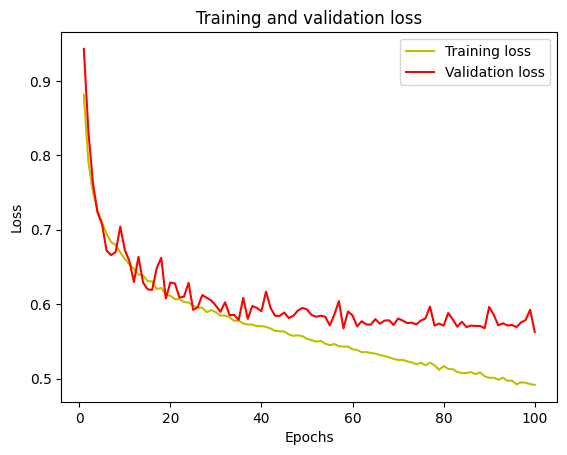

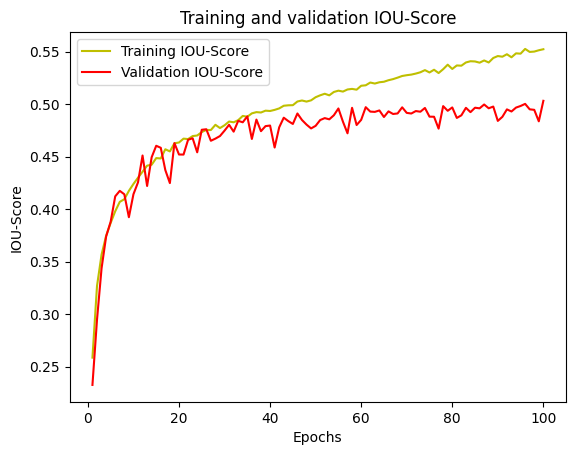

In [20]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['iou_score']
val_acc = history.history['val_iou_score']

plt.plot(epochs, acc, 'y', label='Training IOU-Score')
plt.plot(epochs, val_acc, 'r', label='Validation IOU-Score')
plt.title('Training and validation IOU-Score')
plt.xlabel('Epochs')
plt.ylabel('IOU-Score')
plt.legend()
plt.show()

In [21]:
model.save(f'weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()})-({SIZE_X}x{SIZE_Y})-Patchh(512x512).hdf5')

In [12]:
model.load_weights(f'weights/{MODEL.upper()}_model_with_{EPOCHS}_epochs({MODEL.upper()}_{BACKBONE.capitalize()})-({SIZE_X}x{SIZE_Y})-Patchh(512x512).hdf5')

In [13]:
model.input_shape, model.output_shape

((None, 256, 256, 3), (None, 256, 256, 10))

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_data_gen_args = dict()
mask_data_gen_args = dict()

image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory(f"{parent_directory}/test_images",
                                                           seed=seed,
                                                           batch_size=Batch_size,
                                                           class_mode=None,
                                                           target_size=(SIZE_X, SIZE_Y))

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory(f"{parent_directory}/test_masks",
                                                         seed=seed,
                                                         batch_size=Batch_size,
                                                         color_mode = 'grayscale',
                                                         class_mode=None,
                                                         target_size=(SIZE_X, SIZE_Y))


test_generator = zip(image_generator, mask_generator)

Found 15680 images belonging to 1 classes.
Found 15680 images belonging to 1 classes.


In [15]:
test_images_seperate, _ = test_generator.__next__()

In [18]:
test_generator = load_data(image_generator, mask_generator, preprocess_input)

In [19]:
test_images, test_masks = test_generator.__next__()

In [20]:
test_images.shape, test_masks.shape

((16, 256, 256, 3), (16, 256, 256, 10))

In [ ]:
test_images, test_masks = load_images(parent_directory, split='test')
test_images_seperate = test_images

In [ ]:
data_to_save = {
    'test_images': test_images,
    'test_masks': test_masks,
    'test_images_seperate': test_images_seperate
}

pickle_file_path = f'../../dataset/test_data({SIZE_X}x{SIZE_Y}).pickle'

with open(pickle_file_path, 'wb') as pickle_file:
    pickle.dump(data_to_save, pickle_file)

print(f'Data saved to {pickle_file_path}')

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

In [ ]:
pickle_file_path = f'../../dataset/test_data({SIZE_X}x{SIZE_Y}).pickle'

with open(pickle_file_path, 'rb') as pickle_file:
    loaded_data = pickle.load(pickle_file)

test_images = loaded_data['test_images']
test_masks = loaded_data['test_masks']
test_images_seperate = loaded_data['test_images_seperate']

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

In [ ]:
test_images, test_masks = preprocess_data(test_images, test_masks, preprocess_input)

print('Shapes of loaded data:')
print('Test Images:', test_images.shape)
print('Test Masks:', test_masks.shape)

## Test Evaluation and Perfomance

In [21]:
_, acc = model.evaluate(test_images, test_masks, verbose=0)
print("Accuracy is = ", (acc * 100.0), "%")

Accuracy is =  63.55739235877991 %


In [22]:
from keras.metrics import MeanIoU
import numpy as np

y_pred = model.predict(test_images)
predicted_masks = np.argmax(y_pred, axis=-1)
test_masks_ = np.argmax(test_masks, axis=-1)

print(predicted_masks.shape)
print(test_masks_.shape)

1/1 [==============================] - 1s 883ms/step
(16, 256, 256)
(16, 256, 256)


In [23]:
class_names = ["Background", "Building Flooded", "Building Non-Flooded", "Road Flooded", "Road Non-Flooded",
               "Water", "Tree", "Vehicle", "Pool", "Grass"]

n_classes = len(class_names)  
IOU_keras = MeanIoU(num_classes=n_classes)

IOU_keras.update_state(test_masks_, predicted_masks)
print("Mean IoU =", IOU_keras.result().numpy())

values = np.array(IOU_keras.get_weights())
values = values.reshape(n_classes, n_classes)

class_IoUs = []
print("IoU for each class:")
for i in range(n_classes):
    if i == 0: 
        continue
    class_IoU = values[i, i] / (np.sum(values[i, :]) + np.sum(values[:, i]) - values[i, i])
    class_IoUs.append(class_IoU)
    print(f"{class_names[i]}: {class_IoU}")

mean_IoU_without_background = np.mean(class_IoUs)
print("Mean IoU (excluding Background):", mean_IoU_without_background)

Mean IoU = 0.63948786
IoU for each class:
Building Flooded: 0.9586206674575806
Building Non-Flooded: 0.0
Road Flooded: 0.5795193910598755
Road Non-Flooded: 0.9231045246124268
Water: 0.7212786674499512
Tree: 0.6303378939628601
Vehicle: 0.8671109676361084
Pool: 0.0
Grass: 0.9120850563049316
Mean IoU (excluding Background): 0.6213397


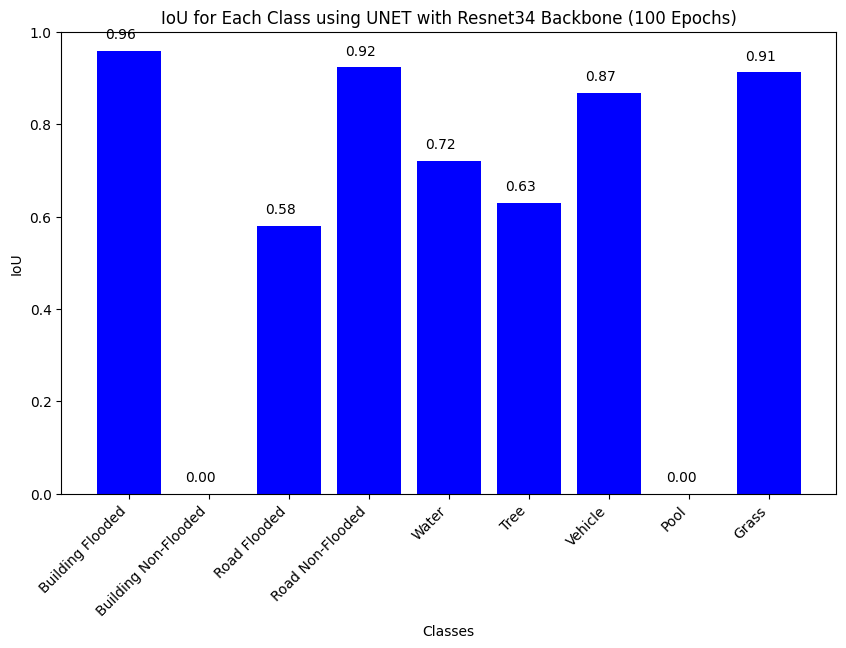

In [24]:
plt.figure(figsize=(10, 6))
bars = plt.bar(class_names[1:], class_IoUs, color='blue')
plt.title(f'IoU for Each Class using {MODEL.upper()} with {BACKBONE.capitalize()} Backbone ({EPOCHS} Epochs)')
plt.xlabel('Classes')
plt.ylabel('IoU')
plt.ylim(0, 1) 
plt.xticks(rotation=45, ha='right')  

for bar, value in zip(bars, class_IoUs):
    plt.text(bar.get_x() + bar.get_width() / 2 - 0.1, bar.get_height() + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()

In [25]:
def calculate_iou(ground_truth_mask, predicted_mask):
    intersection = np.logical_and(ground_truth_mask, predicted_mask)
    union = np.logical_or(ground_truth_mask, predicted_mask)
    iou = np.sum(intersection) / np.sum(union)
    return iou

In [26]:
iou_of_each_image = {}
for i in range(len(test_images)):
    iou = calculate_iou(test_masks_[i], predicted_masks[i])
    iou_of_each_image[i] = iou

## Samples Visualization

In [52]:
def display_random_function():
    image_id = np.random.randint(0, len(test_images))
    # image = test_images_seperate[image_id].astype(np.int32)
    image = test_images[image_id].astype(np.int32)
    ground_truth_mask = test_masks_[image_id]
    predicted_mask = predicted_masks[image_id]

    print(f'Image Shape: {image.shape}')
    print(f'Ground Truth Mask Shape: {ground_truth_mask.shape}')
    print(f'Predicted Mask Shape: {predicted_mask.shape}')

    iou = calculate_iou(ground_truth_mask, predicted_mask)
    print(f'IoU for this image: {iou}')

    display_images_with_masks(image, ground_truth_mask, predicted_mask)

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)
IoU for this image: 1.0


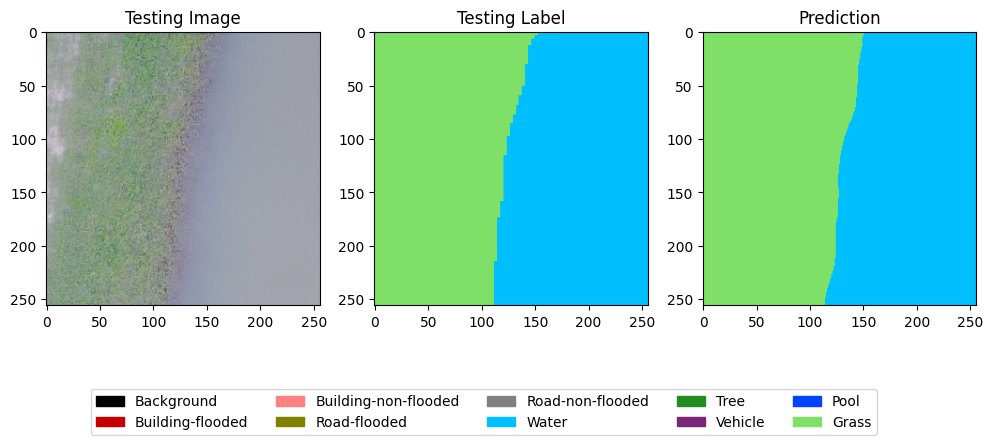

In [61]:
display_random_function()

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)
IoU for this image: 1.0


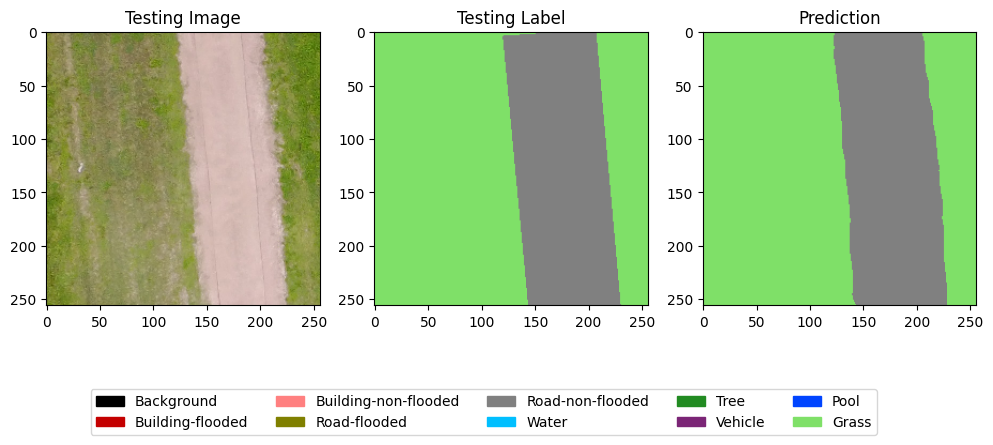

In [64]:
display_random_function()

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)
IoU for this image: 1.0


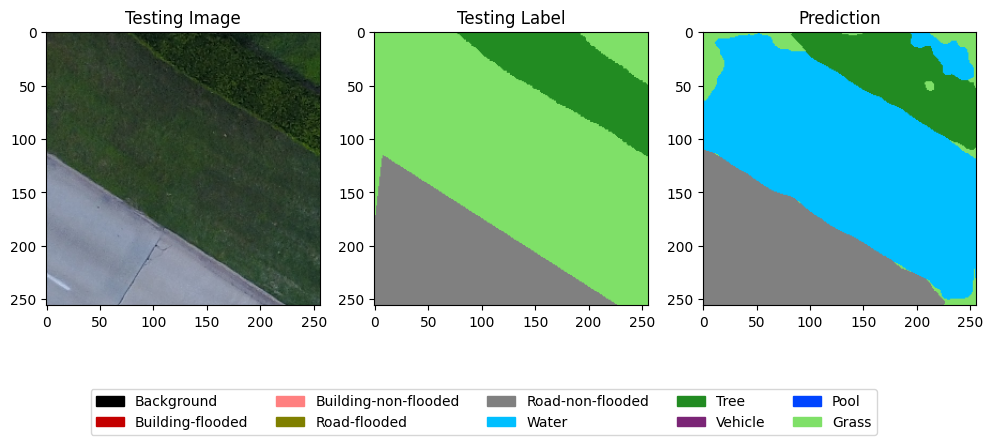

In [65]:
display_random_function()

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)
IoU for this image: 1.0


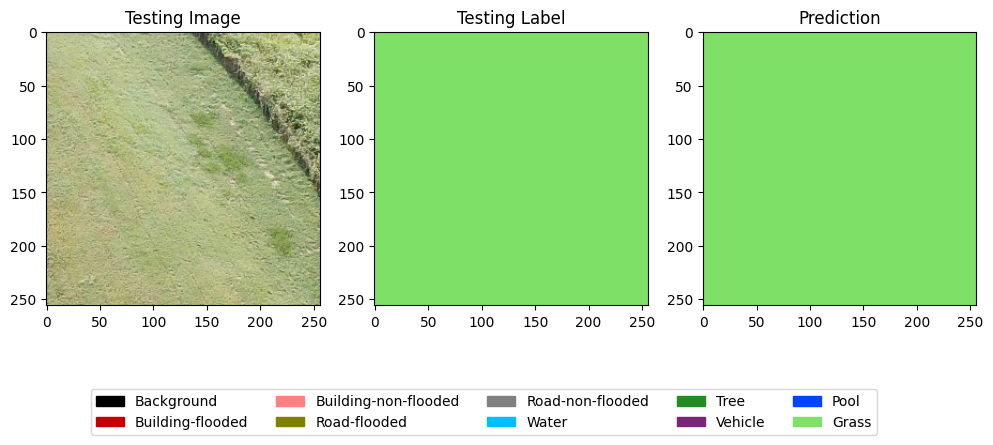

In [56]:
display_random_function()

Image Shape: (256, 256, 3)
Ground Truth Mask Shape: (256, 256)
Predicted Mask Shape: (256, 256)
IoU for this image: 1.0


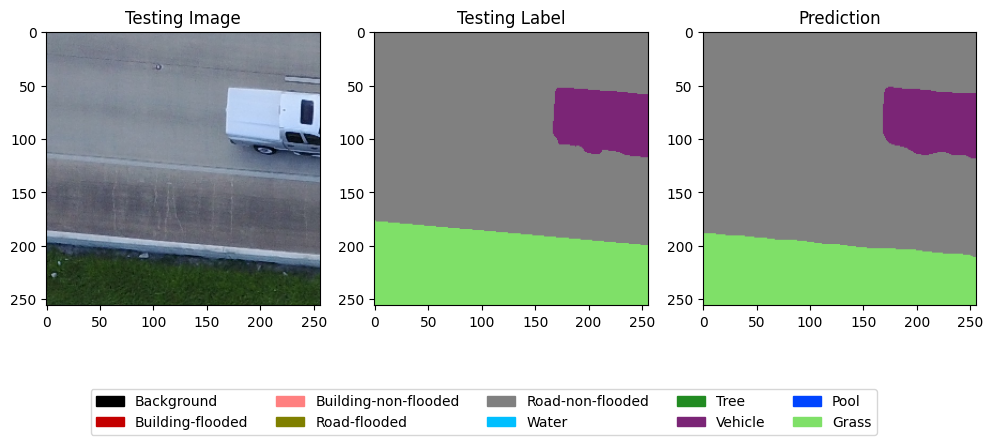

In [66]:
display_random_function()

## Smooth Blending

In [92]:
image_path = r"E:\Segmentation\datasets\FloodNet-Supervised_v1.0\test\test-org-img\11483.jpg"

image = cv2.imread(image_path)
mask = cv2.imread(image_path.replace("org", "label").replace("jpg", "png"))
mask = mask[:, :, 0]

print(image.shape)
print(mask.shape)

(3000, 4000, 3)
(3000, 4000)


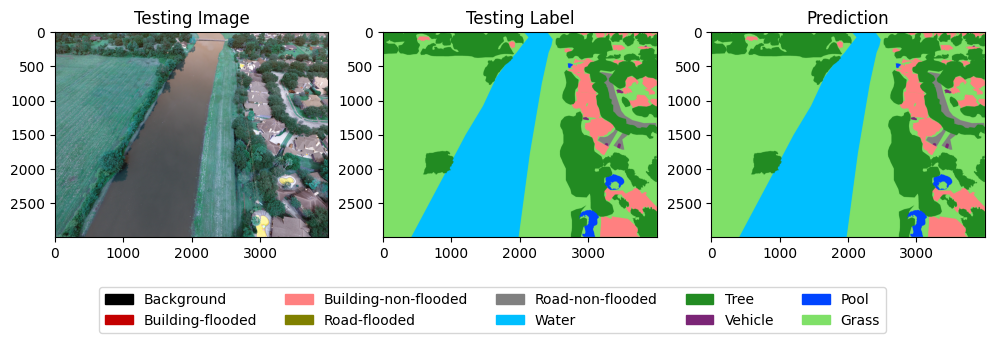

In [93]:
display_images_with_masks(image, mask, mask)

In [94]:
image = sm.get_preprocessing(BACKBONE)(image)

print(image.shape)
print(mask.shape)

(3000, 4000, 3)
(3000, 4000)


In [95]:
from smooth_tiled_predictions import predict_img_with_smooth_windowing

predictions_smooth = predict_img_with_smooth_windowing(
    image,
    window_size=256,
    subdivisions=2,
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)

  0%|          | 0/8 [00:00<?, ?it/s]

24/24 [==============================] - 2s 87ms/step


 12%|█▎        | 1/8 [00:11<01:18, 11.26s/it]

24/24 [==============================] - 2s 85ms/step


 25%|██▌       | 2/8 [00:23<01:11, 11.87s/it]

24/24 [==============================] - 2s 88ms/step


 38%|███▊      | 3/8 [00:35<00:58, 11.77s/it]

24/24 [==============================] - 2s 87ms/step


 50%|█████     | 4/8 [00:47<00:47, 11.78s/it]

24/24 [==============================] - 2s 90ms/step


 62%|██████▎   | 5/8 [01:00<00:36, 12.33s/it]

24/24 [==============================] - 2s 89ms/step


 75%|███████▌  | 6/8 [01:11<00:24, 12.09s/it]

24/24 [==============================] - 2s 83ms/step


 88%|████████▊ | 7/8 [01:23<00:11, 11.92s/it]

24/24 [==============================] - 2s 91ms/step


100%|██████████| 8/8 [01:35<00:00, 11.95s/it]


In [96]:
final_prediction = np.argmax(predictions_smooth, axis=2)
final_prediction = to_RGB(np.tile(np.expand_dims(final_prediction, axis=-1), (1, 1, 3)))
rgb_mask = to_RGB(np.tile(np.expand_dims(mask, axis=-1), (1, 1, 3)))
print(final_prediction.shape, mask.shape)


plt.imsave('predictions/image.jpg',image)
plt.imsave('predictions/mask.jpg', rgb_mask)
plt.imsave('predictions/prediction.jpg', final_prediction)

(3000, 4000, 3) (3000, 4000)


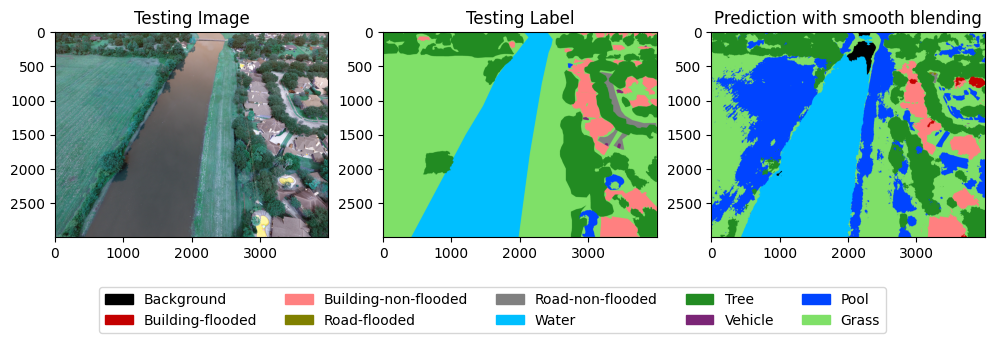

In [97]:
plt.figure(figsize=(12, 8))
plt.subplot(131)
plt.title('Testing Image')
plt.imshow(image)
plt.subplot(132)
plt.title('Testing Label')
plt.imshow(rgb_mask)
plt.subplot(133)
plt.title('Prediction with smooth blending')
plt.imshow(final_prediction)
plt.legend(handles, labels, bbox_to_anchor =(-0.8,-0.5), loc='lower center', ncol=5)
fig1 = plt.gcf()
fig1.savefig("predictions/result_full_image.jpg", dpi=100)
plt.show()